# CNN 성능 향상 (overfitting $\downarrow$, accuracy $\uparrow$)

<img src = "http://cmseng.skku.edu/CMSLecture/ML/img/23-1.png" style="max-width: 60%; height: auto;"><p>

---
<img src = "http://cmseng.skku.edu/CMSLecture/ML/img/23-2.png" style="max-width: 60%; height: auto;"><p>

# Image Data Augmentation
---
- 원본 이미지에 적절한 변형을 가해서 새로운 데이터를 만들어 내는 방식
- 즉 원본 이미지를 상하좌우 방향으로 조금 이동하거나, 약간 회전 또는 기울이거나 또는 확대 등의 여러가지 변화을 조합해 이미지 데이터 개수를 증가시킴.

### Image Data Augmentation 장점
- 다양한 데이터를 입력시킴으로써 모델을 더욱 견고하게 만들어 주기때문에 더 높음 성능을 기대할 수 있음.
- CNN 모델을 학습 시키기에 수집된 데이터가 적은 경우 강력한 힘을 발휘함.
---
<img src = "http://cmseng.skku.edu/CMSLecture/ML/img/22-2.png" style="max-width: 60%; height: auto;"> <p>

<img src = "http://cmseng.skku.edu/CMSLecture/ML/img/22-4.png" style="max-width: 60%; height: auto;"> <p>


# Tensorflow version 2.12.0 사용

In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.__version__

'2.12.0'

## [1] CIFAR 10 데이터 불러오기 및 정규화

In [5]:
# CIFAR-10 데이터셋을 읽고 신경망에 입력할 형태로 변환
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)


## [2] CIFAR 10 데이터 보강 (150% 증대)
### ImageDataGenerator obj 생성

In [4]:
gen = ImageDataGenerator(rotation_range=20,
                         shear_range=0.2,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         horizontal_flip=True)

## 보강할 학습데이터 이미지 생성
- np.random.randint 사용법: <code>np.random.randint?</code> ex) np.random.randint(10,size=12)

In [11]:
np.random.randint(10,size=12)

array([5, 2, 3, 7, 1, 3, 7, 7, 0, 6, 6, 5])

In [12]:
# 보강할 학습데이터 이미지 생성

augment_ratio = 1.5   # 전체 데이터의 150%
augment_size = int(augment_ratio * x_train.shape[0])

print(augment_size)    # 75,000

# 전체 x_train 개수의 150% 비율만큼
randidx = np.random.randint(x_train.shape[0], size=augment_size)   # 50,0000개 데이터에서 75,000개를 랜덤하게 선택 

# 임의로 선택된 데이터는 원본데이터를 참조하기 때문에
# 원본데이터에 영향을 줄수 있음. 그래서 copy() 함수를 통해 안전하게 복사본 만듬
x_augmented = x_train[randidx].copy()  
y_augmented = y_train[randidx].copy()

print(x_augmented.shape, y_augmented.shape)

#  이미지 보강 실행
x_augmented, y_augmented = gen.flow(x_augmented, y_augmented, 
                                    batch_size=augment_size,
                                    shuffle=False).next()

print(x_augmented.shape, y_augmented.shape)

75000
(75000, 32, 32, 3) (75000, 1)
(75000, 32, 32, 3) (75000, 1)


In [13]:
# x_train, y_train 에 보강된 데이터 추가

x_train = np.concatenate( (x_train, x_augmented) )
y_train = np.concatenate( (y_train, y_augmented) )

print(x_train.shape, y_train.shape)

(125000, 32, 32, 3) (125000, 1)


# [3] CNN 모델 구축

---
- <code>kernel_size=(3,3), filters=32</code> $\rightarrow$  <code>32,(3,3) </code>
- filter 개수, node 개수 등은 경험적으로 최적의 parameter 결정. 혹은 hyperparameter optimization으로 최적화.
---

In [14]:
# CNN 모델 구축

cnn=Sequential()

cnn.add(Conv2D(32,(3,3),activation='relu', padding='same',input_shape=(32,32,3)))
cnn.add(Conv2D(32,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64,(3,3),activation='relu', padding='same'))
cnn.add(Conv2D(64,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(128,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(256,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())

cnn.add(Dense(128,activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(10,activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [3]:
gen = ImageDataGenerator(rotation_range = 30,
                         width_shift_range=0.3,
                         shear_range=0.4,
                         horizontal_flip=True)

# [4] CNN 모델 컴파일 및 학습

In [15]:
from datetime import datetime

start_time = datetime.now()

cnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

hist = cnn.fit(x_train, y_train, batch_size=256, 
               epochs=250, validation_data=(x_test, y_test),verbose=1)

end_time = datetime.now()

print('Elapsed Time => ', end_time-start_time)

Epoch 1/250
489/489 [==============================] - 127s 256ms/step - loss: 1.7569 - accuracy: 0.3408 - val_loss: 1.3686 - val_accuracy: 0.4897
Epoch 2/250
489/489 [==============================] - 130s 265ms/step - loss: 1.3413 - accuracy: 0.5190 - val_loss: 1.0479 - val_accuracy: 0.6189
Epoch 3/250
489/489 [==============================] - 128s 262ms/step - loss: 1.1692 - accuracy: 0.5878 - val_loss: 0.9120 - val_accuracy: 0.6731
Epoch 4/250
489/489 [==============================] - 126s 258ms/step - loss: 1.0612 - accuracy: 0.6283 - val_loss: 0.8254 - val_accuracy: 0.7095
Epoch 5/250
489/489 [==============================] - 125s 256ms/step - loss: 0.9780 - accuracy: 0.6598 - val_loss: 0.7837 - val_accuracy: 0.7245
Epoch 6/250
489/489 [==============================] - 128s 262ms/step - loss: 0.9246 - accuracy: 0.6818 - val_loss: 0.7372 - val_accuracy: 0.7453
Epoch 7/250
489/489 [==============================] - 130s 265ms/step - loss: 0.8659 - accuracy: 0.7015 - val_loss: 0

In [16]:
cnn.evaluate(x_test, y_test)

313/313 [==============================] - 12s 37ms/step - loss: 0.4299 - accuracy: 0.8732


[0.42994365096092224, 0.873199999332428]

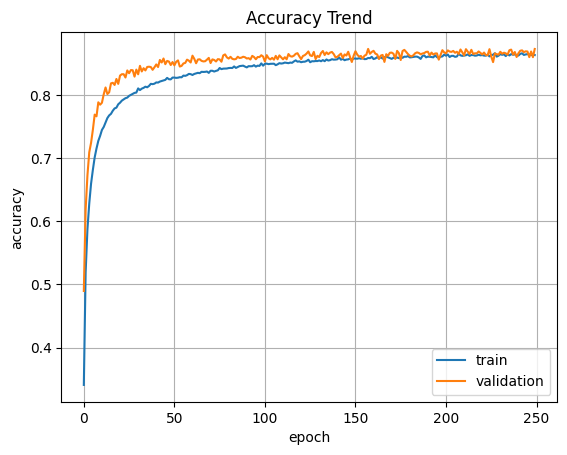

In [17]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='best')
plt.grid()
plt.show()

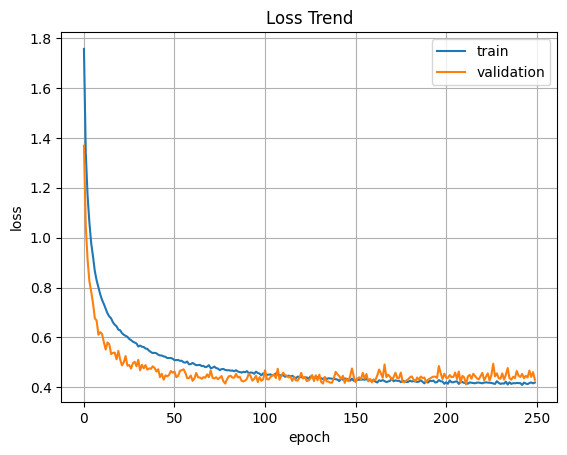

In [18]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='best')
plt.grid()
plt.show()

<img src = "http://cmseng.skku.edu/CMSLecture/ML/img/23-3.png" style="max-width: 60%; height: auto;"> <p>